In [1]:
PYTHON_PATHS = [".."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
import pytorch_lightning as pl
import os
from pytorch_lightning.utilities.parsing import AttributeDict
from pytorch_lightning.loggers import TensorBoardLogger

In [2]:
# import matplotlib.pyplot as plt
# import kornia

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
from lieposenet.utils.universal_factory import UniversalFactory
from lieposenet.models.pose_net import PoseNet
from lieposenet.criterions.pose_net_criterion import PoseNetCriterion
from lieposenet.criterions.se3_criterion import SE3Criterion
from lieposenet.data import SevenScenesDataModule

factory = UniversalFactory([PoseNet, PoseNetCriterion, SE3Criterion])

In [5]:
from clearml import Task, Logger

/usr/local/lib/python3.9/dist-packages/clearml/backend_interface/task/models.py:38: DeprecationWarning: Flags not at the start of the expression '((?i)(Using model id' (truncated)
  _input_models_re = re.compile(r"((?i)(Using model id: )(\w+)?)")


In [6]:
task = Task.init(project_name="lie-pose-net", task_name="LiePoseNet on local machine")

ClearML Task: created new task id=ef9e7840a4ad4faca6b3d37b7b61e5b4


/usr/local/lib/python3.9/dist-packages/nbconvert/exporters/html.py:110: DeprecationWarning:

'contextfilter' is renamed to 'pass_context', the old name will be removed in Jinja 3.1.



ClearML new version available: upgrade to v1.0.5 is recommended!
ClearML results page: https://app.community.clear.ml/projects/04b664f021694b21aadb7a6f50ab46f1/experiments/ef9e7840a4ad4faca6b3d37b7b61e5b4/output/log


# Load datamodule

In [7]:
data_module_params = {
    "batch_size": 64,
    "use_test": True,
    "num_workers": 4,
    "image_size": 256,
    "scene": "fire",
    "data_path": "/media/mikhail/Data3T/7scenes"
}
task.connect(data_module_params)
scene = data_module_params["scene"]
data_module = SevenScenesDataModule(**data_module_params)

/usr/local/lib/python3.9/dist-packages/IPython/core/inputsplitter.py:21: DeprecationWarning:

IPython.core.inputsplitter is deprecated since IPython 7 in favor of `IPython.core.inputtransformer2`



[ToyDataModule] - train subset size 2000
[ToyDataModule] - validation dataset size 2000


# Model

In [8]:
model_params =  AttributeDict(**{
    "name": "PoseNet",
    "feature_extractor": AttributeDict(
        pretrained=True
    ),
    "criterion": {
        "name": "SE3Criterion",
        "rotation_koef": -3.0,
        "translation_koef": -3.0,
    },
    "feature_dimension": 2048,
    "drop_rate": 0,
    "optimizer": AttributeDict(
        betas="0.9 0.999",
        lr=0.0001,
        weight_decay=0.0005,
    ),
    "scheduler": {
        "step_size": 20,
        "gamma": 0.5,
    },
    "bias": True,
    "activation": "tanh",
    "pretrained": True
})
task.connect(model_params)
model = factory.make_from_parameters(model_params)

/usr/local/lib/python3.9/dist-packages/nbconvert/exporters/html.py:135: DeprecationWarning:

'jinja2.Markup' is deprecated and will be removed in Jinja 3.1. Import 'markupsafe.Markup' instead.

/usr/local/lib/python3.9/dist-packages/nbconvert/exporters/html.py:135: DeprecationWarning:

'jinja2.Markup' is deprecated and will be removed in Jinja 3.1. Import 'markupsafe.Markup' instead.

/usr/local/lib/python3.9/dist-packages/nbconvert/filters/ansi.py:60: DeprecationWarning:

'jinja2.escape' is deprecated and will be removed in Jinja 3.1. Import 'markupsafe.escape' instead.

/usr/local/lib/python3.9/dist-packages/nbconvert/filters/ansi.py:60: DeprecationWarning:

'jinja2.escape' is deprecated and will be removed in Jinja 3.1. Import 'markupsafe.escape' instead.

/usr/local/lib/python3.9/dist-packages/nbconvert/filters/ansi.py:60: DeprecationWarning:

'jinja2.escape' is deprecated and will be removed in Jinja 3.1. Import 'markupsafe.escape' instead.

/usr/local/lib/python3.9/dist-packages/

2021-09-06 20:57:02,740 - clearml.model - INFO - Selected model id: a22c91c76a0f4ef791b13c6d45497aa2


# Train

In [9]:
logger_path = os.path.join(os.path.dirname(task.cache_dir), "lightning_logs", "lieposenet")
# logger_path = 'lightning_logs'
trainer_params = {
    "max_epochs": 1,
    "checkpoint_every_n_val_epochs": 10,
    "gpus": 1,
    "check_val_every_n_epoch": 2
}
task.connect(trainer_params)
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_loss',
    every_n_val_epochs=trainer_params["checkpoint_every_n_val_epochs"])
trainer = factory.kwargs_function(pl.Trainer)(
    logger=TensorBoardLogger(logger_path, name=scene),
    callbacks=[model_checkpoint],
    **trainer_params
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [10]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type         | Params
---------------------------------------------------
0 | criterion         | SE3Criterion | 6     
1 | feature_extractor | ResNet       | 22.3 M
2 | final_fc          | Linear       | 57.4 K
---------------------------------------------------
22.4 M    Trainable params
0         Non-trainable params
22.4 M    Total params
89.571    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'mean_rotation': 22.91289520263672,
 'mean_translation': 0.5174035429954529,
 'median_position_error': 0.4988696873188019,
 'median_rotation_error': 18.21623992919922,
 'mse_log_se3': 0.10168445110321045,
 'mse_log_se3_rotation': 0.08561597019433975,
 'mse_log_se3_translation': 0.11775291711091995,
 'mse_rotation': 3.425203323364258,
 'mse_translation': 0.11283605545759201,
 'test_loss': -4.543307781219482}
--------------------------------------------------------------------------------


[{'test_loss': -4.543307781219482,
  'mean_translation': 0.5174035429954529,
  'mean_rotation': 22.91289520263672,
  'mse_translation': 0.11283605545759201,
  'mse_rotation': 3.425203323364258,
  'mse_log_se3': 0.10168445110321045,
  'mse_log_se3_rotation': 0.08561597019433975,
  'mse_log_se3_translation': 0.11775291711091995,
  'median_position_error': 0.4988696873188019,
  'median_rotation_error': 18.21623992919922}]

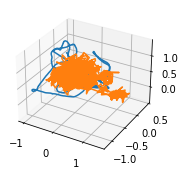

In [11]:
trainer.test(model, data_module.test_dataloader())

In [15]:
batch = None
for x in data_module.test_dataloader():
    batch = x
    break

In [17]:
output, losses = model.loss(batch)

In [19]:
output.shape

torch.Size([64, 28])

In [26]:
pose = batch["position"]

In [41]:
rotation = model.criterion.rotation(output)

In [51]:
torch.norm(torch.nn.functional.normalize(output[:, 3:7]), dim=1, p=2)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], grad_fn=<NormBackward1>)

In [42]:
kornia.quaternion_exp_to_log(rotation)

tensor([[ 2.4626,  1.4650, -0.0040],
        [ 2.2819,  1.6622,  0.4203],
        [ 2.2597,  1.7119,  0.4642],
        [ 2.1607,  1.8306,  0.4486],
        [ 2.1913,  1.8109,  0.3120],
        [ 2.1775,  1.8476,  0.2799],
        [ 2.2580,  1.7014,  0.4704],
        [ 2.2556,  1.7073,  0.4468],
        [ 2.4184,  1.5768,  0.2951],
        [ 2.4187,  1.5480,  0.2551],
        [ 2.4656,  1.5342, -0.3016],
        [ 2.5197,  1.3966,  0.2061],
        [ 2.2961,  1.7739,  0.0131],
        [ 2.5424,  1.4279, -0.2021],
        [ 2.3977,  1.6019,  0.4026],
        [ 2.3514,  1.6843,  0.1865],
        [ 2.3074,  1.7418,  0.3383],
        [ 2.6318,  1.2872,  0.3626],
        [ 2.6453,  1.2683, -0.0098],
        [ 2.5360,  1.4452,  0.2112],
        [ 2.2957,  1.7353,  0.0786],
        [ 2.2058,  1.8354,  0.2603],
        [ 2.5080,  1.4663, -0.1308],
        [ 2.1986,  1.8480,  0.0113],
        [ 2.4002,  1.5945,  0.2736],
        [ 2.4060,  1.5564,  0.2308],
        [ 2.5297,  1.3586,  0.0694],
 

In [24]:
import kornia

In [25]:
kornia.quaternion_exp_to_log(position.q_rotation)

tensor([[ 2.4626,  1.4650, -0.0040],
        [ 2.2819,  1.6622,  0.4203],
        [ 2.2597,  1.7119,  0.4642],
        [ 2.1607,  1.8306,  0.4486],
        [ 2.1913,  1.8109,  0.3120],
        [ 2.1775,  1.8476,  0.2799],
        [ 2.2580,  1.7014,  0.4704],
        [ 2.2556,  1.7073,  0.4468],
        [ 2.4184,  1.5768,  0.2951],
        [ 2.4187,  1.5480,  0.2551],
        [ 2.4656,  1.5342, -0.3016],
        [ 2.5197,  1.3966,  0.2061],
        [ 2.2961,  1.7739,  0.0131],
        [ 2.5424,  1.4279, -0.2021],
        [ 2.3977,  1.6019,  0.4026],
        [ 2.3514,  1.6843,  0.1865],
        [ 2.3074,  1.7418,  0.3383],
        [ 2.6318,  1.2872,  0.3626],
        [ 2.6453,  1.2683, -0.0098],
        [ 2.5360,  1.4452,  0.2112],
        [ 2.2957,  1.7353,  0.0786],
        [ 2.2058,  1.8354,  0.2603],
        [ 2.5080,  1.4663, -0.1308],
        [ 2.1986,  1.8480,  0.0113],
        [ 2.4002,  1.5945,  0.2736],
        [ 2.4060,  1.5564,  0.2308],
        [ 2.5297,  1.3586,  0.0694],
 

In [40]:
x = kornia.rotation_matrix_to_quaternion(pose[:, :3, :3].clone())
y = kornia.quaternion_exp_to_log(x)
z = kornia.quaternion_log_to_exp(y)
z1 = kornia.quaternion_exp_to_log(z)
z1 - y

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.4901e-08, -1.4901e-08, -1.4901e-08],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -7.4506e-09, -7.4506e-09],
        [-1.4901e-08,  7.4506e-09,  7.4506e-09],
        [ 0.0000e+00, -7.4506e-09, -7.4506e-09],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  7.4506e-09,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  7.4506e-09],
        [-1.4901e-08,  7.4506e-09,  7.4506e-09],
        [ 0.0000e+00, -3.7253e-09,  0.0000e+00],
        [-1.4901e-08,  3.7253e-09,  7.4506e-09],
        [-1.4901e-08,  3.7253e-09,  7.4506e-09],
        [-1.4901e-08,  7.4506e-09,  1.4901e-08],
        [ 2.9802e-08, -1.1176e-08, -1.4901e-08],
        [-1.4901e-08,  3.7253e-09,  7.4506e-09],
        [-1.4901e-08,  7.4506e-09,  1.4901e-08],
        [ 0.0000e+00,  3.7253e-09,  0.0000e+00],
        [ 0.0000e+00

In [36]:
torch.norm(kornia.rotation_matrix_to_quaternion(pose[:, :3, :3].clone()), dim=1, p=2)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

In [31]:
from lieposenet.utils.torch_math import *

In [33]:
torch.mean(quaternion_angular_error(kornia.rotation_matrix_to_quaternion(pose[:, :3, :3].clone()), 
                                    position.q_rotation))

tensor(32.5035, grad_fn=<MeanBackward0>)

In [12]:
truth_position = model._data_saver["truth_position"]
predicted_position = model._data_saver["predicted_position"]

In [13]:
Logger.current_logger().report_scatter3d(title="trajectory", series="truth_positions", iteration=1, 
                                         scatter=truth_position,
     xaxis="x", yaxis="y", zaxis="z", mode="lines")
Logger.current_logger().report_scatter3d(title="trajectory", series="predicted_position", iteration=1, 
                                         scatter=predicted_position,
     xaxis="x", yaxis="y", zaxis="z", mode="lines")

In [14]:
task.close()

2021-09-06 20:57:44,619 - clearml.Task - INFO - Waiting to finish uploads
2021-09-06 20:57:45,872 - clearml.Task - INFO - Finished uploading
